# Задача 1


### DTMF технология



In [15]:
from scipy.fftpack import fft, ifft, fftshift
import numpy as np
import matplotlib.pyplot as plt

keys = ['1','2','3','4','5','6','7','8','9','*','0','#']
rowTones = np.array([697, 770, 852, 941]);
colTones = np.array([1209, 1336, 1477]);
fs = 8000
ts = 1/8000

phoneNumber = '89057428569'
phoneNumber = list(phoneNumber)
phoneNumber

['8', '9', '0', '5', '7', '4', '2', '8', '5', '6', '9']

In [16]:
def encode(phoneNumber):
    y = [0]
    for char in phoneNumber:
        try :
            i = keys.index(char)
        except ValueError as e:
            print(e)
            continue
        ind1 = rowTones[(i)//3] #row
        ind2 = colTones[(i)%3] #column
        #print(ind1,',',ind2)
        # длительность нажатия
        dur1=0.3
        #dur1=0.3 + 0.2*np.random.uniform(-1/2,1/2);
        # длительность тишины
        dur2=0.15
        #dur2=0.15 + 0.1*np.random.uniform(-1/2,1/2);

        t = np.arange(0,dur1,ts)
        sig = np.sin(2*np.pi*ind1*t) + np.sin(2*np.pi*ind2*t)    
        n = int(dur2*fs)

        y = y + list(sig) + [0] * n
        
    y_orig = y
    y = np.array(y) + 0.5 * np.random.randn(len(y))
    print('SNR: ', mySNR(y_orig, y))
    return y

SNR:  -1.421855806539053


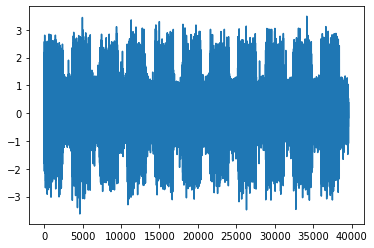

In [17]:
y = encode(phoneNumber)
plt.plot(y)

In [11]:
import IPython
IPython.display.Audio(y,rate=fs)

Как обнаружить закодированные частоты?

**В папке signals есть 10 тестовых сигналов, которые надо раскодировать и понять, какой номер был набран.**

In [ ]:
for i in range(10):
    fs, sig = wavfile.read('signals\phoneNumber'+str(i)+'.wav')
    ...

# Задача 2

В файле 1.3 STFT был пример использования оконного преобразования Фурье для решения задачи классификации звуков на примере датасета ECS10.

Используя датасет ESC50 

https://github.com/karolpiczak/ESC-50

обучить классификатор аналогичным образом на основе оконного преобразования Фурье. 


In [198]:
import pandas as pd
from tqdm import tqdm
import librosa
import numpy as np
import torch
import torch.nn as nn

dataset = pd.read_csv('D:\Temp\esc50.csv')

In [199]:
dataset

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


Вычисление ОПФ

In [200]:
path = "D:\\Temp\\ECS50\\"

wave_file=dataset.filename[0]
audio, sample_rate = librosa.load(path+wave_file)
freq = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
freq.shape

(1025, 216)

Формируем массив с ОПФ

In [201]:
stft=[]
path = "D:\\Temp\\ECS50\\"

for i in tqdm(range(len(dataset))):
    wave_file=dataset.filename[i]
    audio, sample_rate = librosa.load(path+wave_file)
    freq = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    freq=freq.reshape(-1)
    stft.append(freq)


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:24<00:00, 82.91it/s]


In [202]:
stft[0].shape

(221400,)

In [147]:
221400/1025

216.0

Нормализация данных

In [203]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(stft)

normalized_stft = scaler.transform(stft)

print(np.amax(stft))
print(np.amax(normalized_stft))

3.8146973e-06
1.0000000000000568


In [204]:
features_convolution = np.reshape(normalized_stft,(2000, 1, 1025, -1))
features_convolution.shape

(2000, 1, 1025, 216)

One-hot encoding для меток классов

In [211]:
labels = np.array(dataset.target)

def encode_labels(labels, num_of_classes): #encoding the classes into a tensor of shape (11) with 0 and 1s.
    num = len(labels)
    target = torch.zeros(num, num_of_classes).float()
    for i, l in enumerate(labels):
        target[i, l] = 1
    return target

target = encode_labels(labels, 50)
print(target.shape)
print(target[1])

torch.Size([2000, 50])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [210]:
labels[1]

14

Датасет:

In [212]:
X = features_convolution
y = target

Стратифицированное разбиение на тестовую и тренировочную части. Стратифицированное значит, что количество примеров для каждого из классов одинаково в обучающей и тестовой выборке (по 32 и 8 соответственно).

In [213]:
from sklearn.model_selection import StratifiedShuffleSplit
# Initialize the StratifiedShuffleSplit object
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Split the data into training and testing sets
for train_index, test_index in sss.split(X, y):
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]

print("Size of the training set : ", X_train.shape, y_train.shape )
print("Size of the testing set : ", X_test.shape, y_test.shape  )

#train_df = train_df[['data','target']]
#test_df = test_df[['data','target']]



Size of the training set :  (1600, 1, 1025, 216) torch.Size([1600, 50])
Size of the testing set :  (400, 1, 1025, 216) torch.Size([400, 50])


In [214]:
print("Size of the training set : ", X_train.shape, y_train.shape )
print("Size of the testing set : ", X_test.shape, y_test.shape  )


Size of the training set :  (1600, 1, 1025, 216) torch.Size([1600, 50])
Size of the testing set :  (400, 1, 1025, 216) torch.Size([400, 50])


Далее, подобрать модель и обучить. 
...

# ЗАДАЧА 3

Разработать полосно-заграждающий КИХ-фильтр для удаления шума одной частоты из аудио-сигнала. Подгрузим сигнал.
Для того, чтобы качество очищения от шума можно было услышать, добавим шум на частоте, например, 500 Гц.

In [2]:
from scipy.io import wavfile

import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftshift, rfft
from scipy import signal
import IPython

def myDFT_AmplPlot(t, x, N=512, fs = False, xLim = 0.5):
    
    if len(x)>512:
        N = len(x)
        
    xFFT = fftshift(fft(x, N))
    # Амплитуда спектра
    xA = np.abs(xFFT)

    xList = [x, xA]
    titles = ['Сигнал', 'Спектр']

    # Графики
    plt.figure(figsize=(12, 6))
    for i, sig in enumerate(xList):
        plt.subplot(2, 2, i+1)
        plt.title(titles[i])
        if i == 0:
            plt.plot(t, sig)
            plt.xlabel('Временные отсчёты')
            #plt.xlim([-0.25, len(x)-0.75])
        else:
            if fs == False:
                plt.plot(np.arange(-np.floor(N/2), np.floor((N+1)/2))/N,sig)
                plt.xlabel('Частотные отсчёты')
                plt.xlim([0, xLim])
                plt.xticks(np.linspace(0, xLim, 11))
            else:
                plt.plot(fs*np.arange(-np.floor(N/2), np.floor((N+1)/2))/N,sig)
                plt.xlabel('Частоты')
                plt.xlim([0, fs*xLim])
                plt.xticks(np.linspace(0, fs*xLim, 11))
        plt.grid()
    plt.tight_layout()

In [3]:
fs, data = wavfile.read('source/LetsGo.wav')
data = data/np.max(data)

C:\Users\AlexK\AppData\Local\Temp\ipykernel_13140\3373649784.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data = wavfile.read('source/LetsGo.wav')


In [4]:
IPython.display.Audio(data, rate=fs)

In [5]:
w = 500
t = np.arange(0,len(data)) / fs
noise = np.sin(2*np.pi*w*t)
y_noised = data + 0.75*noise

IPython.display.Audio(y_noised, rate=fs)

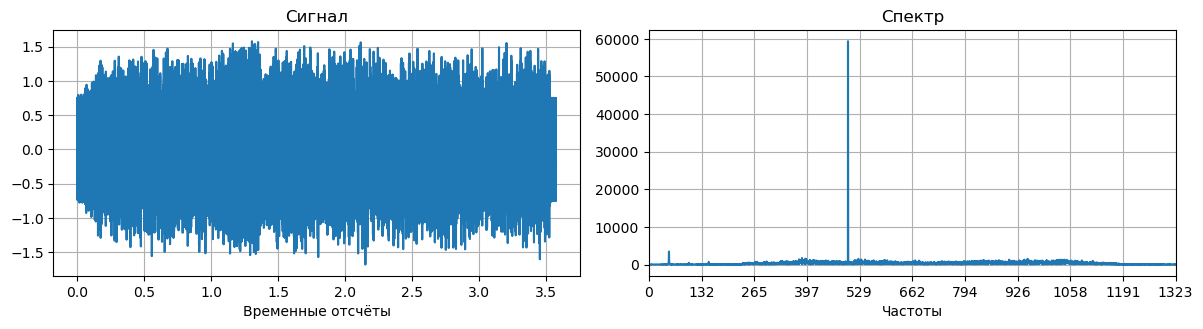

In [6]:
myDFT_AmplPlot(t, y_noised, fs = fs, xLim=0.03)

Создать фильтр одним из способов

    signal.remez()
    signal.firls()
    signal.firwin() 

In [ ]:
....

bs_filter=...
...

In [ ]:
# Вывод АЧХ фильтра
w, h = signal.freqz(bs_filter, [1], fs=fs)

plot_response(w, h, fs, "Band-stop Filter")
plt.xlim(0, 0.05*fs)

Провести фильтрацию сигнала...

In [ ]:
y_filt = ...

In [ ]:
# график отфильтрованного сигнала
myDFT_AmplPlot(t, y_filt, fs = fs, xLim=0.03)

Сравнение спектров исходного сигнала и отфильтрованного.

In [ ]:
yFFT = np.abs(fft(y_filt))
dataFFT = np.abs(fft(data))
N = len(yFFT)
sig = np.array([dataFFT, yFFT]).T
t= np.arange(N)*fs/N

plt.plot(t,sig)
plt.xlabel('Частоты')
plt.xlim([0, fs*0.05])

# Задача 4

Напишите код для генерации звучания ноты по заданной частоте в герцах и длительности в секундах с помощью фильтра Карплюса-Стронга. 

In [ ]:
from random import random
from scipy.io.wavfile import write
from scipy.signal import lfilter, freqz

import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display

# получение коэффициентов фильтра Карплюса-Стронга
def get_KS_filter(M, alpha):
    b = np.array([1]) 
    a = np.array([1] + ([0]*(M-1)) + [-alpha]) 
    return b,a   

In [ ]:
# код для генерации ноты
def get_note(freq, dur, fs):    
    ...
    return sig 

In [ ]:
Далее, для формирования мелодии по списку нот (или частот) удобно написать специальный метод:

In [ ]:
def get_melody(melody, fs):
    dur = 0.5
    x = []
    for note in melody:
        x = x + list(get_note(note, dur, fs))        
    
    return np.array(x)

Сформируем некоторую мелодию.


In [ ]:
notes = ['A', 'A#', 'Bb', 'B', 'C', 'C#', 'Db', 'D', 'D#', 'Eb', 'E', 'F', 'F#', 'Gb', 'G', 'G#', 'Ab']
valueSet = [0,1,1,2,3,4,4,5,6,6,7,8,9,9,10,11,11]

noteDict = dict(zip(notes, valueSet))

song = ['A','A','E','E' ,'F#' ,'F#','E', 'E', 'D','D', 'C#','C#','B','B','A']

melody = [440 * 2 ** (noteDict[note]/12) for note in song]

In [ ]:
x = get_melody(melody, fs)

display.Audio(x, rate=44100, embed=True)

 # Задача 5
 
 В файле `LMS on.ipynb` был реализован LMS алгоритм для фильтрации сигнала. 
 
 Требуется решить ту же задачу фильтрации сигнала с помощью фильтра Винера.

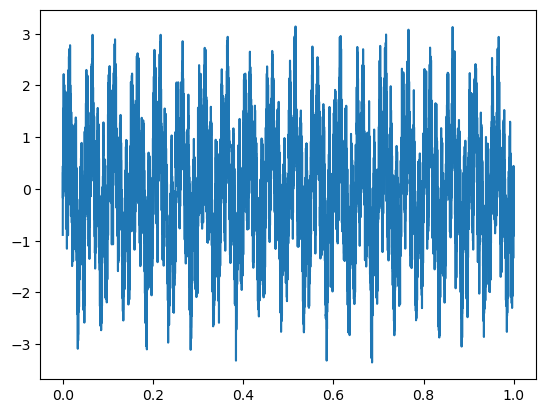

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# Создаём сигнал
t = np.linspace(0,1,10000, endpoint = False)
# желаемый сигнал
desired = np.sin(2*np.pi*20*t)
# сигнал на входе
sig = desired + 0.5*np.random.randn(len(desired)) + np.sin(2*np.pi*80*t)

plt.plot(t,sig)

In [ ]:
X_train = sig[:int(len(sig) * 0.8)]
X_test = sig[int(len(sig) * 0.8):]

Y_train = desired[:int(len(desired) * 0.8)]
Y_test = desired[int(len(desired) * 0.8):]

Найти коэффициенты фильтра Винера, решением СЛАУ, где значения матрицы и вектора получены с помощью корреляций.

In [ ]:
...
weiner_coefs= ...

In [ ]:
w,h = freqz(weiner_coefs, [1], fs=10000) 

def plot_response(w, h, fs, title):
    plt.figure(figsize=(5,2))
    plt.plot(w, 10*np.log10(np.abs(h)))
    plt.ylim(-40, 5)
    plt.xlim(0, 0.5*fs)
    plt.grid(True)
    plt.xlabel('Частота')
    plt.ylabel('Амплитуда (дБ)')
    plt.title(title)
    
plot_response(w, h, 10000, "НЧ фильтр")
plt.xlim(0, 0.05*10000)

In [ ]:
from scipy.signal import lfilter
s_hat = lfilter(weiner_coefs,[1],X_test)

In [ ]:
plt.plot(Y_test)
plt.plot(s_hat)